##### Import python modules

In [162]:
# Import Python Modules

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import matplotlib.patches as mpatch
import matplotlib.patheffects as pe

from cartopy.feature import ShapelyFeature
from datetime import datetime
from shapely.geometry import Polygon

import h3, jenkspy, warnings

##### Set global variables and display settings

In [163]:
# Display Settings

# Enable the view of all columns
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_colwidth", None)

# Enable the view of all rows
pd.set_option("display.max_rows", None)

# Supress warnings when creating buffer for visualisation
warnings.filterwarnings("ignore")

In [164]:
# Define Global Variables

# ACLED dataset
ukraine_acled_geopandas = gpd.read_file(r"Data\ACLED\UKR_ACLED_MSc.shp")

# Ukraine country boundary
ukraine_boundary_geopandas = gpd.read_file(r"Data\Boundaries\UKR_Boundary.shp")

# Ukraine oblast bondaries
ukraine_oblast_geopandas = gpd.read_file(r"Data\Boundaries\UKR_Adm.shp")

# Global country boudnaries
global_boundary_geopandas = gpd.read_file(r"Data\Boundaries\GLB_Bnd.shp")

# Set display extent values
xmin, ymin, xmax, ymax = ukraine_boundary_geopandas.total_bounds

# Set map coordinate system
map_crs = ccrs.Mercator()

# Start, middle and end dates
date_start, date_mid, date_end = ((datetime(2021,12,1), datetime(2022,2,1), datetime(2022,3,18)))

# ACLED dataset columns to keep (date will be calculated later on)
columns_acled = ["actor1", "event_date", "date", "fatalities", "geometry"] 

# Colours used for map products
colour_ramp = ["ivory", "lightcoral", "firebrick", "darkred"]

# Buffer values used for map products
buffers = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Shapely Feature for the Global boundaries
GLB_outline = ShapelyFeature(global_boundary_geopandas["geometry"], map_crs, edgecolor='k', facecolor='darkseagreen')

# Shapely Feature for the Ukrainian oblasts
oblast_outline = ShapelyFeature(ukraine_oblast_geopandas["geometry"], map_crs, edgecolor='k', facecolor='tan')

##### Create functions for daily statistics

In [165]:
def convert_to_datetime(date):
    
    """

    Convert string date into a datetime object

    Parameters : 
    
        argument 1 (string) : Date to be converted, formatted as "02 March 2022"

    Returns : 

        datetime(argument 1) 
        
    """
    return datetime.strptime(date, "%d %B %Y")

In [166]:
def calculate_datetime_ranges(acled, columns, start, mid, end):
    
    """
    
    Create 3 new acled dataframes for the speicifed date ranges, keeping only those columns of interest

    Parameters : 
    
        argument 1 (geopandas dataframe) : Geopandas dataframe of the ACLED dataset

        argument 2 (list) : List of the columns to keep in with the dataframe

        argument 3 (datetime) : date of the start date

        argument 4 (datetime) : date of the middle date

        argument 5 (datetime) : date of the end date

    Returns : 

        geopandas dataframe : Date range start - end

        geopandas dataframe : Date range start - mid
        
        geopandas dataframe : Date range mid - end

    """

    # Create a new column called "date" and convert the original string dates into datetime
    acled["date"] = acled["event_date"].apply(convert_to_datetime)

    # Create geopandas dataframes for date range start - end
    acled_daterange_se = acled[(acled["date"] >= start) & (acled["date"] <= end)]

    # Create geopandas dataframes for date range start - mid
    acled_daterange_sm = acled[(acled["date"] < mid) & (acled["date"] >= start)]
    
    # Create geopandas dataframes for date range mid - end
    acled_daterange_me = acled[(acled["date"] >= mid) & (acled["date"] <= end)]
    
    return acled_daterange_se[columns].sort_values(by=["date"]), acled_daterange_sm[columns].sort_values(by=["date"]), acled_daterange_me[columns].sort_values(by=["date"])

In [167]:
def calculate_statistics(acled_all):
    
    """
    
    Calculate statistics required for counts, fatalities, actors and locations for future products

    Parameters : 
    
        argument 1 (geopandas dataframe) : Geopandas dataframe of the ACLED dataset (date range start - end)

    Returns : 

        geopandas dataframe : count, fatalities and actors statistics for start - end

    """

    # Store unique dates in a list
    unique_dates_set = set(acled_all["date"].tolist())
    unique_dates = list(unique_dates_set)
    unique_dates.sort()

    # Create dictionary to store statistics
    statistics_by_date = {
        "date" : [],
        "count" : [],
        "fatalities" : [],
        "count_sum" : [],
        "fatalities_sum" : [], 
        "russian_actor" : [],
        "ukraine_actor" : [],
        "other_actor" : []
    }
    
    # Create counter variables
    count_sum = 0
    count_fatal = 0

    # Iterate over unique dates to create daily statistics
    for date in unique_dates:

        # Calculate daily statistics
        daily_count = acled_all["date"].value_counts()[date]
        daily_fatal = acled_all.loc[acled_all["date"] == date, "fatalities"].sum()
        daily_events = acled_all[acled_all["date"] == date]
        daily_russian = len(daily_events[daily_events["actor1"].str.contains("Russia")])
        daily_ukraine = len(daily_events[daily_events["actor1"].str.contains("Ukraine")])
        daily_other = daily_count - daily_russian - daily_ukraine

        # Append daily statistics
        statistics_by_date["date"].append(date)
        statistics_by_date["count"].append(daily_count)
        statistics_by_date["fatalities"].append(daily_fatal)
        statistics_by_date["count_sum"].append(count_sum + daily_count)
        statistics_by_date["fatalities_sum"].append(count_fatal + daily_fatal)
        statistics_by_date["russian_actor"].append(daily_russian)
        statistics_by_date["ukraine_actor"].append(daily_ukraine)
        statistics_by_date["other_actor"].append(daily_other)

        # Update counters
        count_sum += daily_count
        count_fatal += daily_fatal

    return pd.DataFrame(statistics_by_date).sort_values(by=["date"])

In [168]:
def create_acled_graphs(acled_daily_statistics): 
    
    """

    Creates a series of graph products using the datasets previosuly created for daily statistics
    
    """

    # Create figure and axis
    figure_1, (axis_1, axis_2, axis_3) = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

    axis_list = [axis_1, axis_2, axis_3]

    # Set titles
    axis_1.set_title("ACLED : Daily Incidents and Fatalities", 
                    fontsize=18, 
                    loc="left", 
                    weight="bold")

    axis_2.set_title("ACLED : Accumulative Incidents and Fatalities", 
                    fontsize=18, 
                    loc="left", 
                    weight="bold")

    axis_3.set_title("ACLED : Daily Force Activity", 
                    fontsize=18, 
                    loc="left", 
                    weight="bold")

    # Plot daily statistics by date
    axis_1.plot(acled_daily_statistics["date"], 
                acled_daily_statistics["count"], 
                color="yellow", 
                linestyle=":",
                label="Events")

    axis_1.plot(acled_daily_statistics["date"], 
                acled_daily_statistics["fatalities"], 
                color="r", 
                linestyle=":", 
                label="Fatalities")

    axis_2.plot(acled_daily_statistics["date"], 
                acled_daily_statistics["count_sum"], 
                color="yellow", 
                linestyle=":",
                label="Events (3857)")

    axis_2.plot(acled_daily_statistics["date"], 
                acled_daily_statistics["fatalities_sum"],
                color="r", 
                linestyle=":",
                label="Fatalities (2311)")

    axis_3.plot(acled_daily_statistics["date"], 
                acled_daily_statistics["ukraine_actor"], 
                color="blue", 
                linestyle=":",
                label="Ukrainian")

    axis_3.plot(acled_daily_statistics["date"], 
                acled_daily_statistics["russian_actor"], 
                color="red", 
                linestyle=":",
                label="Russian")

    axis_3.plot(acled_daily_statistics["date"], 
                acled_daily_statistics["other_actor"], 
                color="darkorange", 
                linestyle=":",
                label="Other")

    # Set x and y axis labels
    x_ticks = [date_start, datetime(2022,1,1), datetime(2022,2,1), datetime(2022,2,24), date_end]

    y_ticks = [[i for i in range(50, acled_daily_statistics["fatalities"].max() + 50, 50)], 
            [i for i in range(500, acled_daily_statistics["count_sum"].max() + 500, 500)],
            [i for i in range(20, acled_daily_statistics["count"].max() - 20, 20)]]

    # Format styling and legend
    for i, ax in enumerate(axis_list):
        ax.set_facecolor("lightslategray")
        ax.set_xticks(
            ticks=x_ticks, 
            labels=["01 Dec 2021", "01 Jan 2022", "01 Feb 2022", "24 Feb 2022", "18 Mar 2022"],
            fontsize=14
        )
        ax.set_yticks(ticks=y_ticks[i], labels=y_ticks[i], fontsize=14)
        ax.hlines(y=y_ticks[i], xmin=date_start, xmax=date_end, color="whitesmoke", linestyle=":")
        ax.vlines(
            x=mdates.date2num(datetime(2022,2,24)), 
            ymin=0, 
            ymax=y_ticks[i][-1],
            color="k", 
            linestyle=":",
            alpha=0.5,
            label="Russian Invasion of Ukraine - 24 February 2022"
        )
        ax.legend(fontsize=14, loc="upper left", facecolor="slategray")

##### Create Functions for Oblast statistics

In [169]:
def count_by_oblast(oblasts, acled):
    
    """
    
    Count the occurances and fatalities for each region

    Parameters : 

        argument 1 (geopandas dataframe) : Geopandas dataframe of the country boundaries dataset
    
        argument 2 (geopandas dataframe) : Geopandas dataframe of the ACLED dataset

    Returns : 

        statistics for each oblast (geopandas dataframe) : region, count, fatalities and geometry

    """

    # Create dictionary to store statistics
    statistics_by_oblast = {
        "Region" : [],
        "count" : [],
        "fatalities" : []
    }

    # Perform Spatial Join
    acled_oblast_sj = gpd.sjoin(oblasts, acled, how='inner', lsuffix='left', rsuffix='right')

    # Get a list of all region names
    unique_regions = set(acled_oblast_sj['Region'].tolist())
    unique_regions = list(unique_regions)
    unique_regions.sort()

    # Update dictionary for regions, counts and fatalities
    for region in unique_regions:
        fatal = acled_oblast_sj.loc[acled_oblast_sj["Region"] == region, "fatalities"].sum()
        count = acled_oblast_sj["Region"].value_counts()[region]

        statistics_by_oblast["Region"].append(region)#.split(" region")[0])
        statistics_by_oblast["count"].append(count)
        statistics_by_oblast["fatalities"].append(fatal)

    # Convert dictionary into pandas dataframe
    statistics_by_oblast_pandas = pd.DataFrame(statistics_by_oblast)

    # Merge regions statistics to oblast regions to link geometry
    oblast_statistics = statistics_by_oblast_pandas.merge(oblasts[["Region", "geometry"]])

    # Calculate values for Natural Breaks Jenks
    oblast_statistics["NBJ"] = pd.cut(oblast_statistics["count"], bins=jenkspy.jenks_breaks(oblast_statistics["count"], nb_class=4), labels=[1,2,3,4], include_lowest=True)
    
    return oblast_statistics

In [170]:
def create_oblast_graphs(oblast_statistics):
    """

    Creates a series of graph products using the datasets previosuly created for oblast statistics
    
    """

    # Create figure and axis
    figure_2, (axis_4, axis_5) = plt.subplots(nrows=1, ncols=2, figsize=(60,20))

    axis_list = [axis_4, axis_5]

    # Reverse A-Z into Z-A for plot labels
    oblast_statistics = oblast_statistics.sort_values(by="Region", ascending=False)

    # Set titles
    axis_4.set_title("ACLED : Total Events by Ukranian Oblast (01 Dec 21 - 18 Mar 22)", 
                    fontsize=24, 
                    loc="left", 
                    weight="bold")

    axis_5.set_title("ACLED : Total Fatalities by Ukranian Oblast (01 Dec 21 - 18 Mar 22)", 
                    fontsize=24, 
                    loc="left", 
                    weight="bold")

    # Plot oblast_statistics
    axis_4.barh(oblast_statistics["Region"], oblast_statistics["count"], color="yellow", alpha=0.5)
    axis_5.barh(oblast_statistics["Region"], oblast_statistics["fatalities"], color="r", alpha=0.5)

    # Set y axis labels
    y_ticks = [[i for i in range(200, oblast_statistics["count"].max() + 200, 200)], [i for i in range(50, oblast_statistics["fatalities"].max() + 50, 50)]]

    # Format styling
    for index, axis in enumerate(axis_list):  
        axis.set_facecolor("lightslategray")
        axis.vlines(x=y_ticks[index], ymin="Autonomous Republic of Crimea", ymax="Zhytomyr region", color="whitesmoke", linestyle=":")
        axis.tick_params(axis='x', labelsize=18)
        axis.tick_params(axis='y', labelsize=18)

    for index, value in enumerate(oblast_statistics["count"]):
        axis_4.text(value + 20, index, str(value), color="k", fontsize=18, va="center")

    for index, value in enumerate(oblast_statistics["fatalities"]):
        axis_5.text(value + 2, index, str(value), color="k", fontsize=18, va="center")  

In [171]:
def create_oblast_map(oblast_statistics):
    """
    
    Creates a map product using the datasets previosuly created for oblast statistics

    """
    
    # Create map figure
    map_oblasts = plt.figure(figsize=(30,15))

    # Create map axes
    map_ax = plt.axes(projection=map_crs)

    # Set map title
    map_ax.set_title("ACLED : Total Events by Ukrainian Oblast (01 Dec 21 - 18 Mar 22)", 
                    fontsize=20, 
                    weight="bold",
                    loc="left")
  
    # Background colour
    map_ax.set_facecolor("skyblue")

    map_ax.add_feature(GLB_outline)

    # Create multiple buffers with opacity for visual effect
    for buffer in buffers:
        UKR_buffer = ukraine_boundary_geopandas.buffer(buffer)
        UKR_buffer = ShapelyFeature(UKR_buffer, map_crs, edgecolor='k', facecolor='black', alpha=buffer)
        map_ax.add_feature(UKR_buffer)

    legend_handle = []

    legend_lable = []

    oblast_statistics = oblast_statistics.sort_values(by="Region")

    # Create colour coded oblast features based on values defined with natural breaks (jenks)
    for index, region in oblast_statistics["Region"].iteritems():

        geom = oblast_statistics["geometry"][oblast_statistics["Region"] == region]

        jenks = oblast_statistics["NBJ"][oblast_statistics["Region"] == region]

        colour = colour_ramp[int(jenks) - 1]
        
        oblast_feature = ShapelyFeature(
            geom,
            map_crs,
            edgecolor="k",
            facecolor=colour
        )

        # Calculate centroid for label placement
        centroid_region = ukraine_oblast_geopandas["geometry"][ukraine_oblast_geopandas["Region"] == region]

        centroid = centroid_region.centroid

        map_ax.add_feature(oblast_feature)

        # Label Oblasts
        if index == 12:
            map_ax.text(centroid.x, centroid.y - 0.4, index, fontsize=16, weight="bold", transform=map_crs, color="ghostwhite", path_effects=[pe.withStroke(linewidth=4, foreground="k")])
        elif index == 11 or index == 19:
            map_ax.text(centroid.x, centroid.y - 0.1, index, fontsize=16, weight="bold", transform=map_crs, color="ghostwhite", path_effects=[pe.withStroke(linewidth=4, foreground="k")])
        elif index == 16:
            map_ax.text(centroid.x + 0.3, centroid.y, index, fontsize=16, weight="bold", transform=map_crs, color="ghostwhite", path_effects=[pe.withStroke(linewidth=4, foreground="k")])
        else:
            map_ax.text(centroid.x, centroid.y, index, fontsize=16, weight="bold", transform=map_crs, color="ghostwhite", path_effects=[pe.withStroke(linewidth=4, foreground="k")])

        legend_handle.append(mpatch.Rectangle((0, 0), 1, 1, facecolor=colour, edgecolor="k"))

        legend_lable.append("ID {} : {} ({})".format(index, region, oblast_statistics["count"][oblast_statistics["Region"] == region][index]))

    map_ax.legend(legend_handle, legend_lable, title="Legend", loc="upper left", framealpha=1, fontsize=14, title_fontsize=16)

    map_ax.set_extent([xmin - 5.5, xmax + 1, ymin - 1, ymax + 1], crs=map_crs)

##### Create Functions for Hexbins

In [172]:
def create_hexbins(acled, map, theme, sorted_NBJ, colour_ramp):

    """
    Create hexbins using Uber h3 geospatial indexing

    Parameters : 

        argument 1 (geopandas dataframe) : ACLED dataset for entire daterange
    
        argument 2 (geopandas dataframe) : Map figure for which to plot the hexbins
        
        argument 3 (string) : Theme for the map (count or fatalities)

        argument 4 (list) : List of sorted natural break (Jenks) values for computing symbology

        argument 4 (list) : List of colour codes for symbology

    Returns : 

        Creates hexbins and plots onto map in argument 2

    """

    # Create dictionaries for storing hexbin data
    acled_to_h3 = {}

    h3_statistics = {
        "Hexbin"  : [],
        "count" : [],
        "fatalities" : [],
        "Geometry" : []
    }

    for n in range(0, len(acled) - 1):

        # Get ACLED XY
        xy = acled.iloc[n]["geometry"]

        # Input X, Y, H3 resolution
        hexbin = h3.geo_to_h3(xy.x, xy.y, 5)

        # Calculate statistics to assign to hexbins
        if hexbin not in acled_to_h3.keys():
            acled_to_h3[hexbin] = {
                "count" : 1,
                "fatalities" : acled.iloc[n]["fatalities"],
                "Boundary" : h3.h3_to_geo_boundary(hexbin, geo_json=False)
             }
        else:
            acled_to_h3[hexbin]["count"] += 1
            acled_to_h3[hexbin]["fatalities"] += acled.iloc[n]["fatalities"]

    # Create dictionary for all hexbins and statistics to turn into DataFrame
    for key, val in acled_to_h3.items():
        h3_statistics["Hexbin"].append(key)
        h3_statistics["count"].append(val["count"])
        h3_statistics["fatalities"].append(val["fatalities"])
        h3_statistics["Geometry"].append(Polygon(val["Boundary"]))

    h3_geopandas = gpd.GeoDataFrame(h3_statistics)

    h3_geopandas.sort_values(by=theme)

    hexbins = h3_geopandas["Hexbin"].values.tolist()

    for hexbin in hexbins:

        count = h3_geopandas.loc[h3_geopandas["Hexbin"] == hexbin, theme].iloc[0]

        # Assign symbology based on NBJ valuess
        if count <= sorted_NBJ[0]:
            colour_ramp_choice = 0
        elif count > sorted_NBJ[0] and count <= sorted_NBJ[1]:
            colour_ramp_choice = 1
        elif count > sorted_NBJ[2] and count <= sorted_NBJ[3]:
            colour_ramp_choice = 2
        else:
            colour_ramp_choice = 3
        
        # Get hexbin geometry
        geom = h3_geopandas['Geometry'][h3_geopandas["Hexbin"] == hexbin]

        # Create Hexbin
        h3_UKR = ShapelyFeature(
            geom,
            map_crs,
            edgecolor="k",
            facecolor=colour_ramp[colour_ramp_choice]
        )

        # Plot hexbin
        map.add_feature(h3_UKR)

In [173]:
def create_hexbin_maps(acled_daterange_sm, acled_daterange_me, acled_daily_statistics):

    """

    Create hexbins using Uber h3 geospatial indexing

    Parameters : 

        argument 1 (geopandas dataframe) : ACLED dataset for daterange start - mid
    
        argument 2 (geopandas dataframe) : ACLED dataset for daterange mid - end
        
        argument 3 (geopandas dataframe) : DataFrame for daily ACLED statistics


    Returns : 

        Creates various hexbin maps for fatalities and counts for the start - mid / mid - end data ranges

    """

    # List of map titles and associated DataFrames
    map_list = {
        "map_hex_count_1" : {"Title" : "ACLED : Event Count for 01 Dec 21 - 31 Jan 22", "GPD" : acled_daterange_sm}, 
        "map_hex_count_2" : {"Title" : "ACLED : Event Count for 01 Feb 22 - 18 Mar 22", "GPD" : acled_daterange_me}, 
        "map_hex_fatal_1" : {"Title" : "ACLED : Fatalities for 01 Dec 21 - 31 Jan 22", "GPD" : acled_daterange_sm}, 
        "map_hex_fatal_2" : {"Title" : "ACLED : Fatalities for 01 Feb 22 - 18 Mar 22", "GPD" : acled_daterange_me}
        }
        
    for map_theme, vals in map_list.items():

        map = plt.figure(figsize=(20,30))

        map_crs = ccrs.Mercator()

        map_ax = plt.axes(projection=map_crs)

        # Set either count or fatalities theme
        if map_theme.startswith("map_hex_count"):
            theme = "count"
        elif map_theme.startswith("map_hex_fatal"):
            theme = "fatalities"

        # Calculate NBJ values for theme
        acled_daily_statistics["NBJ"] = pd.cut(
            acled_daily_statistics[theme],
            bins=jenkspy.jenks_breaks(acled_daily_statistics[theme], nb_class=4),
            include_lowest=True)

        set_NBJ = set(acled_daily_statistics["NBJ"].values.tolist())

        list_NBJ = list(set_NBJ)

        list_sort = []

        # List the max value for each NBJ range
        for i in list_NBJ:
            list_sort.append(int(i.right))

        list_sort.sort()

        leg_handle = []

        leg_lable = []

        # Create legend handles and labels based on theme and NBJ values
        for i, v in enumerate(list_sort):
            
            leg_handle.append(mpatch.Rectangle((0, 0), 1, 1, facecolor=colour_ramp[i], edgecolor="k"))

            if i == 0:
                leg_lable.append("{} : {} - {}".format(theme.capitalize(), 0, list_sort[i]))
            else:
                leg_lable.append("{} : {} - {}".format(theme.capitalize(), list_sort[i-1], list_sort[i]))

        map_ax.set_title(vals["Title"], 
                        fontsize=20, 
                        weight="bold",
                        loc="left")

        map_ax.add_feature(GLB_outline)

        # Create multiple buffers with opacity for visual effect
        for buffer in buffers:
            UKR_buffer = ukraine_boundary_geopandas.buffer(buffer)
            UKR_buffer = ShapelyFeature(UKR_buffer, map_crs, edgecolor='k', facecolor='black', alpha=buffer)
            map_ax.add_feature(UKR_buffer)

        map_ax.legend(leg_handle, leg_lable, title="Legend", loc="upper left", framealpha=1, fontsize=14, title_fontsize=16)

        map_ax.add_feature(oblast_outline)
        map_ax.set_facecolor("skyblue")

        map_ax.set_extent([xmin - 3, xmax + 1, ymin - 1, ymax + 1], crs=map_crs)

        create_hexbins(vals["GPD"], map_ax, theme, list_sort, colour_ramp)

#### Run functions and create products

In [174]:
def run_functions():

    """
    
    Runs all the functions creating all variables, datasets and products
    
    """

    # Tuple unpack returned dataframes
    acled_daterange_se, acled_daterange_sm, acled_daterange_me = calculate_datetime_ranges(ukraine_acled_geopandas, columns_acled, date_start, date_mid, date_end)

    # Assign variables to returned dataframe
    acled_daily_statistics = calculate_statistics(acled_daterange_se)

    # Spatially join ACLED to country oblasts
    oblast_statistics = count_by_oblast(ukraine_oblast_geopandas, acled_daterange_se)

    # Create ACLED Daily Statistics Graphs
    create_acled_graphs(acled_daily_statistics)

    # Create Ukrainian Oblast Graphs
    create_oblast_graphs(oblast_statistics)

    # Create Ukrainian Oblast Map
    create_oblast_map(oblast_statistics)

    # Create Hexbin Maps
    create_hexbin_maps(acled_daterange_sm, acled_daterange_me, acled_daily_statistics)

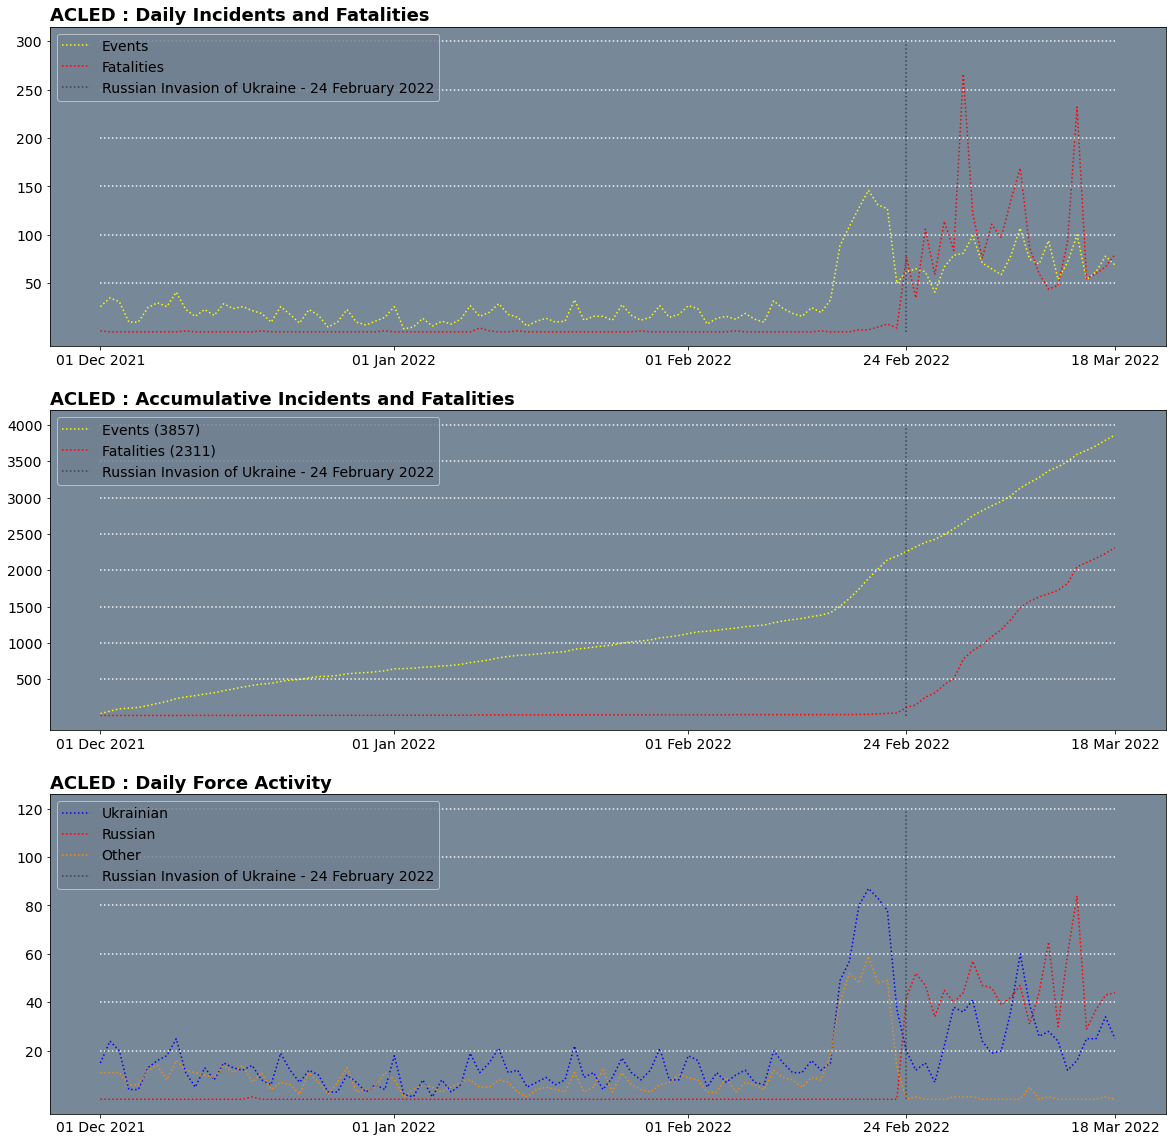

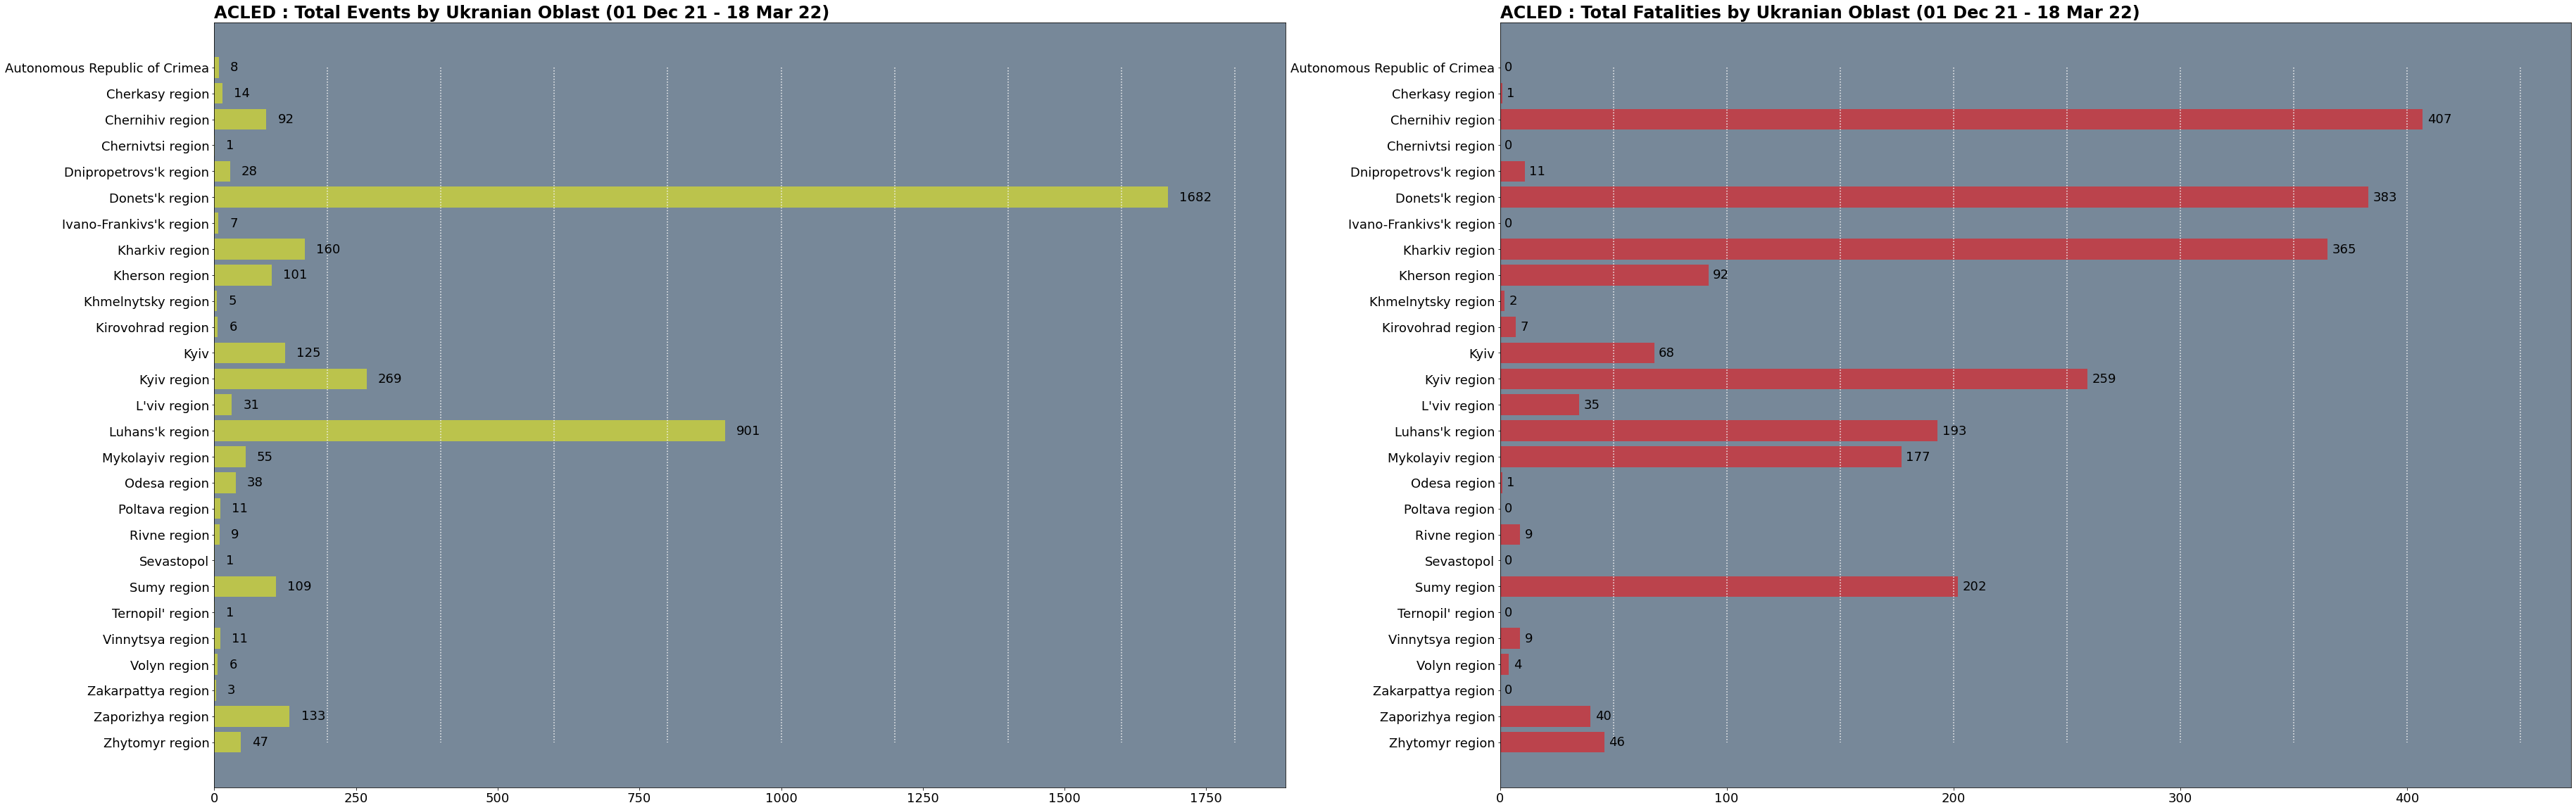

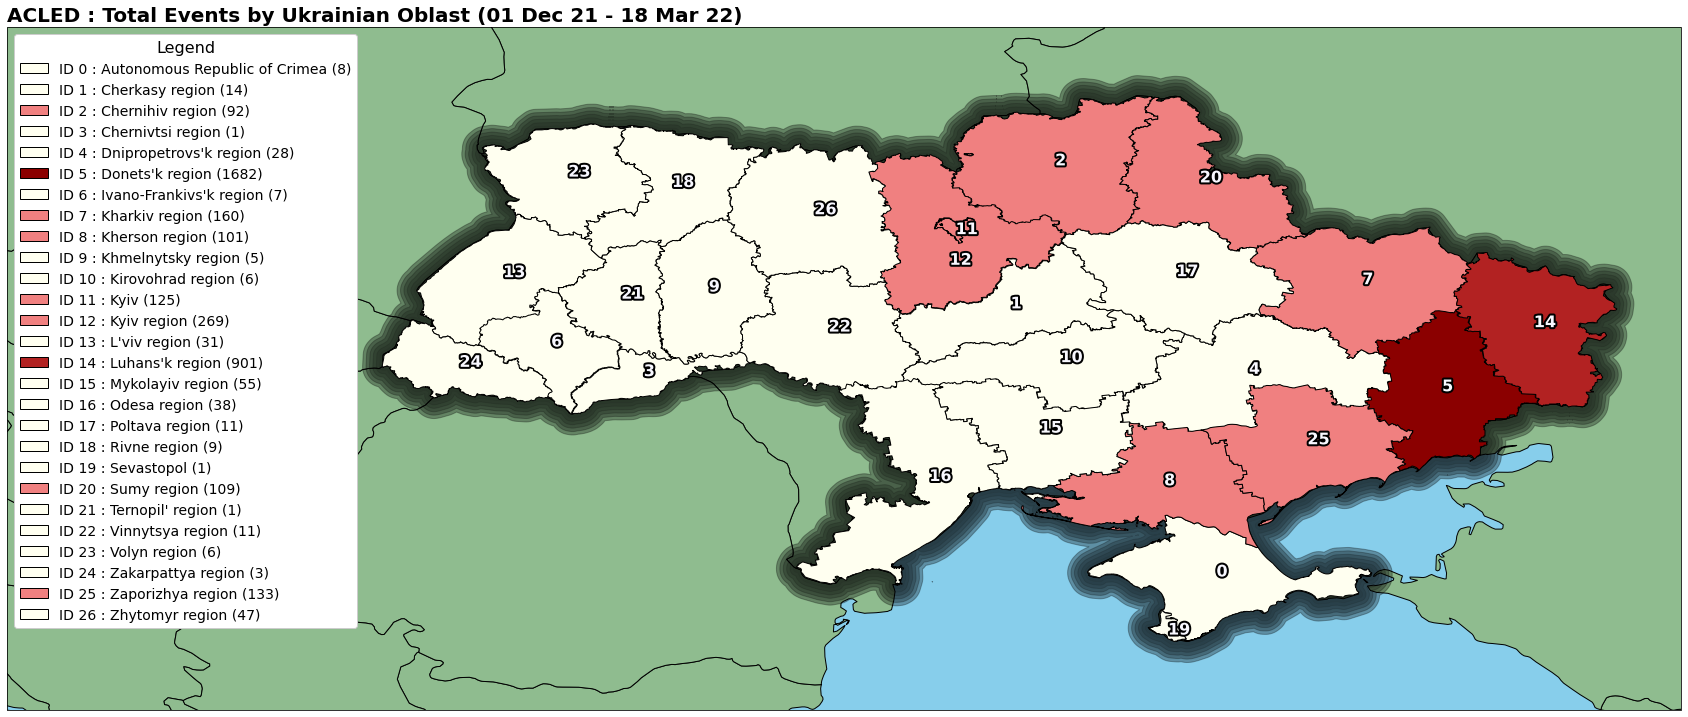

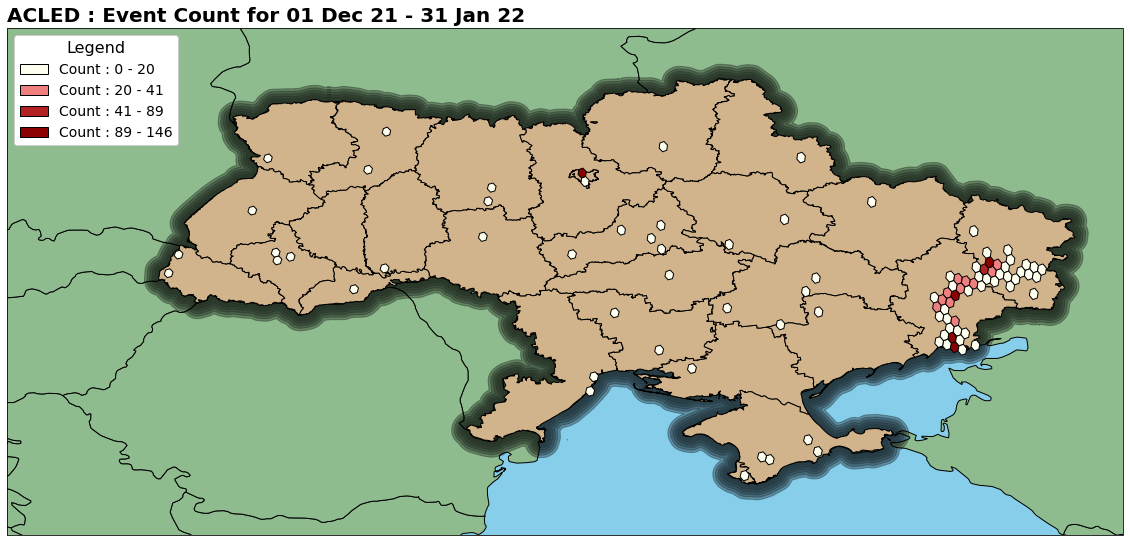

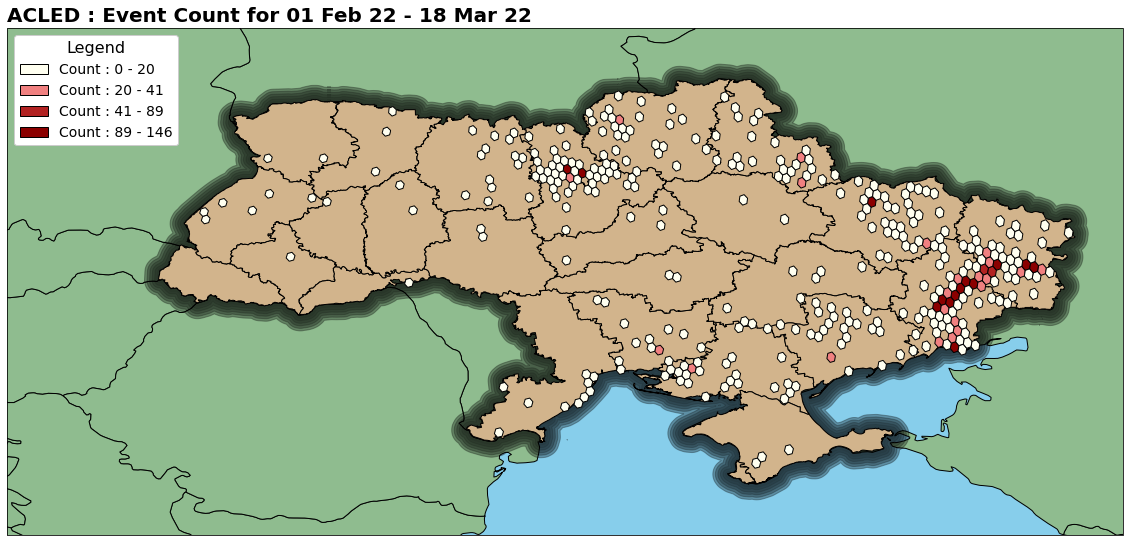

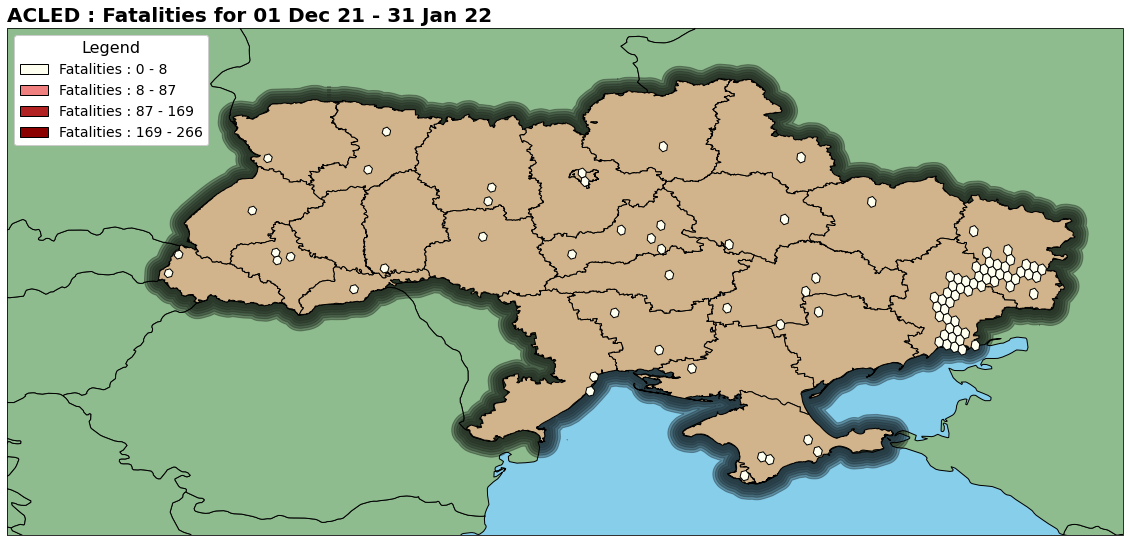

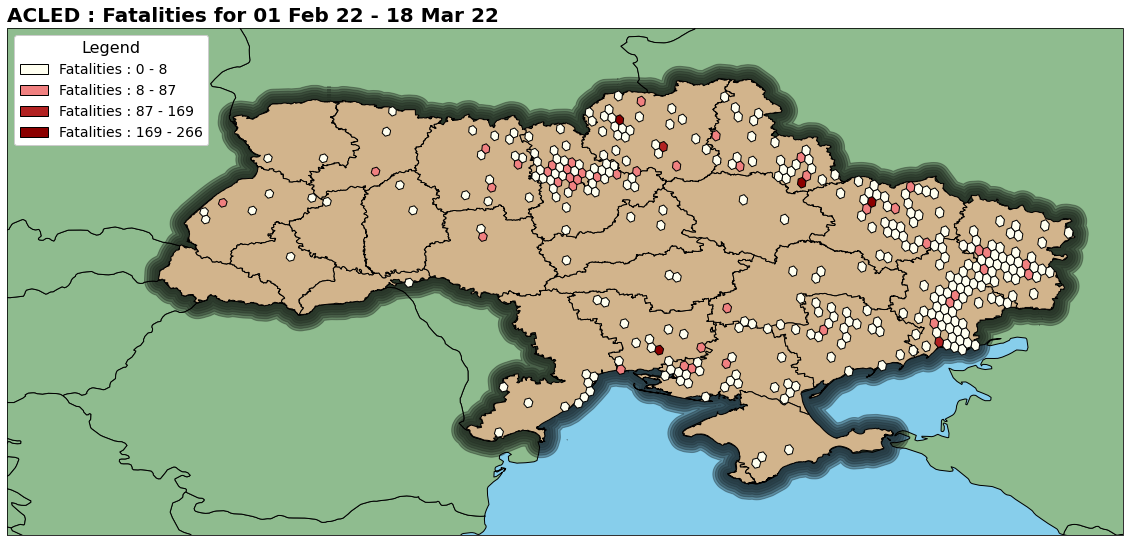

In [175]:
# Run the code
run_functions()